In [252]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from voyager import utils
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import MinMaxScaler

## Get draft positions

In [253]:
years = list(range(2005,2018))

all_dfs = []

for y in years:
    base = f'https://www.pro-football-reference.com/years/{y}/draft.htm'
    dfs = pd.read_html(base, header=1)
    for frame in dfs:
        frame['draft_year'] = y
    all_dfs.append(dfs)

In [254]:
expand = [x for y in all_dfs for x in y]

data = pd.DataFrame()

for frame in expand:
    data = pd.concat([data, frame])

In [255]:
df = data[['draft_year', 'Rnd','Pick', 'Tm', 'Player', 'Pos','G']].copy()
df['Pick'] = pd.to_numeric(df['Pick'], errors='coerce')
df['G'] = pd.to_numeric(df['G'], errors='coerce')
df['Rnd'] = pd.to_numeric(df['Rnd'], errors='coerce')
df = df.dropna()

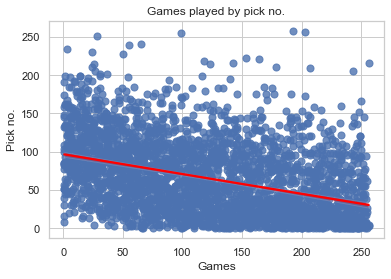

In [256]:
sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.regplot(x='Pick', y='G', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

plt.xlabel('Games')
plt.ylabel('Pick no.')
plt.title('Games played by pick no.')
plt.show()

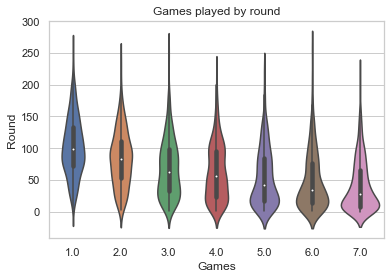

In [257]:
# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style

# Create the violin plot
sns.violinplot(x='Rnd', y='G', data=df)

plt.xlabel('Games')
plt.ylabel('Round')
plt.title('Games played by round')
plt.show()

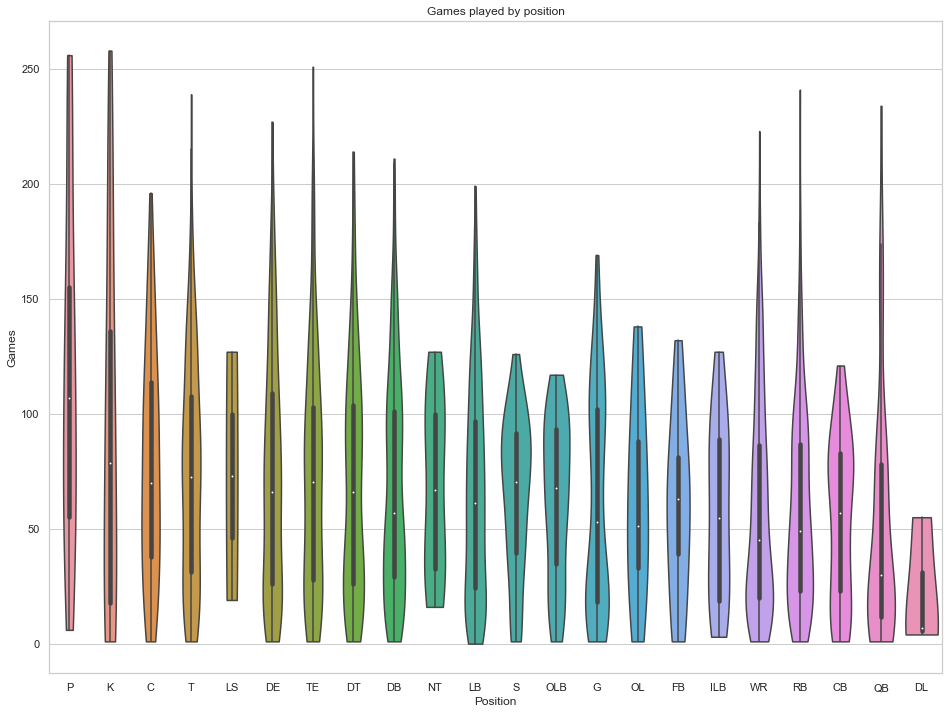

In [258]:
x = 'Pos'
y = 'G'

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(16,12))

mean_values = df.groupby(x)[y].mean()
sorted_x_categories = mean_values.sort_values(ascending=False).index

# Create the violin plot
sns.violinplot(x=x, y=y, data=df, cut=0, order=sorted_x_categories)

plt.xlabel('Position')
plt.ylabel('Games')
plt.title('Games played by position')

plt.show()

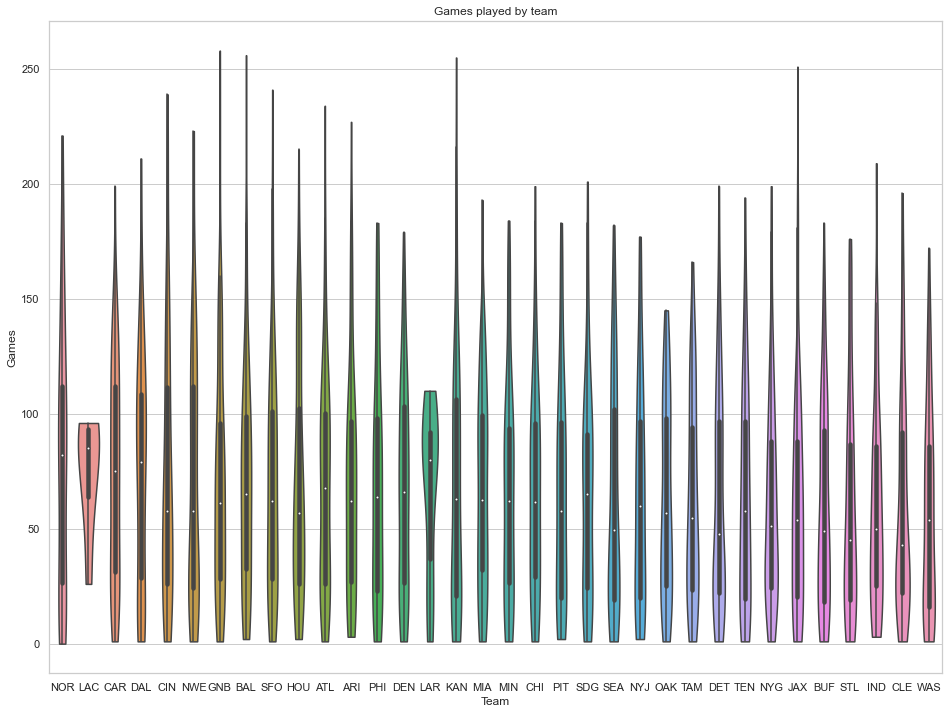

In [259]:
x = 'Tm'
y = 'G'

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(16,12))

mean_values = df.groupby(x)[y].mean()
sorted_x_categories = mean_values.sort_values(ascending=False).index

# Create the violin plot
sns.violinplot(x=x, y=y, data=df, cut=0, order=sorted_x_categories)

plt.xlabel('Team')
plt.ylabel('Games')
plt.title('Games played by team')

plt.show()

In [260]:
df = utils.clean_cols(df)
df.to_pickle('data/draft_data.pkl')

In [261]:
positions = [
    'running-back',
    'quarterback',
    'wide-receiver',
    'tight-end',
    'center',
    'left-tackle',
    'left-guard',
    'right-guard',
    'right-tackle',
    'interior-defensive-line',
    'edge-rusher',
    'linebacker',
    'safety',
    'cornerback',
    ]

all_dfs = []

for pos in positions:
    url = f'https://overthecap.com/contract-history/{pos}'
    data = pd.read_html(url, header=0)
    all_dfs.append(data)

expand = [x for y in all_dfs for x in y]

data = pd.DataFrame()

for frame in expand:
    data = pd.concat([data, frame])

In [262]:
contracts = data[['Player', 'Team', 'Year Signed', 'Value', 'Guaranteed']].copy()
contracts = utils.clean_cols(contracts)
contracts['year_signed'] = pd.to_numeric(contracts['year_signed'], errors='coerce')
contracts['value'] = contracts['value'].str.replace('[\$,]', '', regex=True).astype(int)
contracts['gtd'] = contracts['guaranteed'].replace('[\$,]', '', regex=True).astype(int)
contracts = contracts.drop(columns=['guaranteed'])


In [263]:
c2 = contracts[contracts.groupby('player')['year_signed'].rank() == 2]
c1 = contracts[contracts.groupby('player')['year_signed'].rank() == 1]
c2 = c2.merge(c1[['player', 'year_signed', 'gtd']], how='outer', on='player')

In [264]:
c2.columns = ['player', 'team2', 'year_2', 'value', 'gtd2', 'year_1', 'gtd1']
c2 = c2[['player', 'team2', 'year_1', 'gtd1', 'year_2', 'gtd2']].copy()

In [265]:
## get nfl cap history
url = 'https://www.spotrac.com/nfl/cba/'
cap_data = pd.read_html(url)[0]

In [266]:
cap = cap_data[['Year', 'Cap Maximum']].copy()
cap.columns = ['yr', 'cap']
cap['cap'] = cap['cap'].str.replace('[\$,]', '', regex=True)
cap['cap'] = pd.to_numeric(cap['cap'], errors='coerce')
cap['cap'] = cap['cap'].interpolate(method='linear')

In [267]:
c2 = c2.merge(cap, how='left', left_on='year_1', right_on='yr')
c2 = c2.drop(columns=['yr'])
c2['gtd1_norm'] = c2['gtd1'] / c2['cap']
c2 = c2.drop(columns=['cap'])

c2 = c2.merge(cap, how='left', left_on='year_2', right_on='yr')
c2 = c2.drop(columns=['yr'])
c2['gtd2_norm'] = c2['gtd2'] / c2['cap']
c2 = c2.drop(columns=['cap'])

In [268]:
## fuzzy match
threshold = 80

draft_names = df['player'].unique()
c2_names = df['player'].unique()

# Use fuzzywuzzy's process.extractOne() to find the best match for each name
matches = {}
for name in c2_names:
    match = process.extractOne(name, draft_names, scorer=fuzz.token_sort_ratio)
    if match[1] >= threshold:
        matches[name] = match[0]

df['matching_name'] = df['player'].map(matches)
c2['matching_name'] = c2['player'].map(matches)

In [269]:
df = df.merge(c2[['matching_name', 'gtd1_norm', 'gtd2_norm', 'year_1', 'year_2']], how='left', on='matching_name')

In [270]:
df = df.dropna()
df = df[df['pick']!=0]

In [271]:
c2.to_pickle('data/contract_data.pkl')

## Analysis 

In [273]:
# scale gtds within position groups
# this is to control for the fact that QBs get paid much more
scaler = MinMaxScaler()

cols=['gtd1_norm','gtd2_norm']

def f(x):
    scaler1=MinMaxScaler()
    new_cols = [x+'_scaled' for x in cols]
    x[new_cols] = scaler1.fit_transform(x[cols])
    return x

grouped = df[cols+['pos']].groupby('pos').apply(f)

df = df.join(grouped[['gtd1_norm_scaled', 'gtd2_norm_scaled']], how='left')


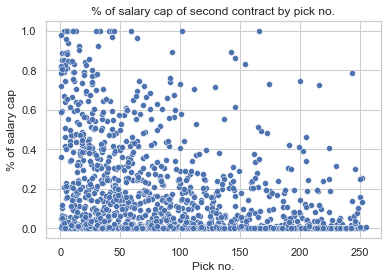

In [274]:
x = df['pick']
y = df['gtd2_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of second contract by pick no.')
plt.show()

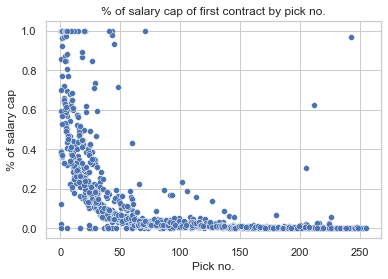

In [276]:
x = df['pick']
y = df['gtd1_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of first contract by pick no.')
plt.show()

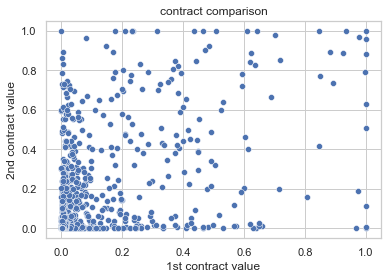

In [279]:
x = 'gtd1_norm_scaled'
y = 'gtd2_norm_scaled'

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df[df['draft_year']> 2010])

plt.xlabel('1st contract value')
plt.ylabel('2nd contract value')
plt.title('contract comparison')
plt.show()

In [281]:
df['gtds_delta'] = df['gtd2_norm_scaled'] - df['gtd1_norm_scaled']

In [300]:
# create pick buckets because data is noisy otherwise
bins = np.linspace(0,df['pick'].max(), 25)
labels = list(range(1, 25))
df['pick_g'] = pd.cut(df['pick'], bins=bins, labels=labels)

delta_g = df[['pick_g', 'gtds_delta']].groupby('pick_g').mean().reset_index()

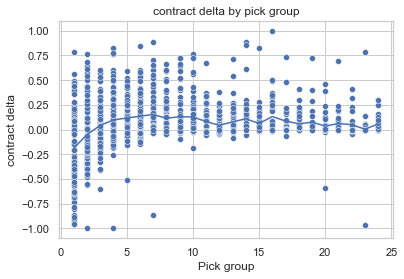

In [303]:
x = df['pick_g']
y = df['gtds_delta']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)
sns.lineplot(x='pick_g', y='gtds_delta', data=delta_g)


plt.xlabel('Pick group')
plt.ylabel('contract delta')
plt.title('contract delta by pick group')
plt.show()

In [334]:
df['gtds_ratio'] = df['gtd2_norm_scaled'] / df['gtd1_norm_scaled']
df['gtds_ratio'] = df['gtds_ratio'].replace(np.inf, np.nan)

ratio_g = df[['pick_g', 'gtds_ratio']].groupby('pick_g').mean().reset_index()

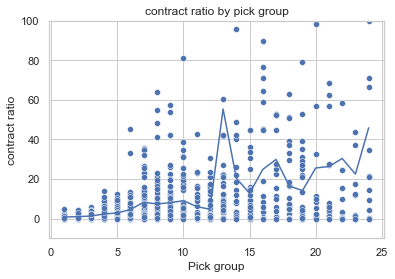

In [337]:
x = df['pick_g']
y = df['gtds_ratio']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)
sns.lineplot(x='pick_g', y='gtds_ratio', data=ratio_g)

plt.ylim((-10,100))
plt.xlabel('Pick group')
plt.ylabel('contract ratio')
plt.title('contract ratio by pick group')
plt.show()

In [338]:
ratio_g

,pick_g,gtds_ratio
0,1,0.754636
1,2,0.956822
2,3,1.244209
3,4,2.285134
4,5,2.834814
5,6,4.560050
6,7,8.217852
7,8,7.393833
8,9,7.990258
9,10,9.032584


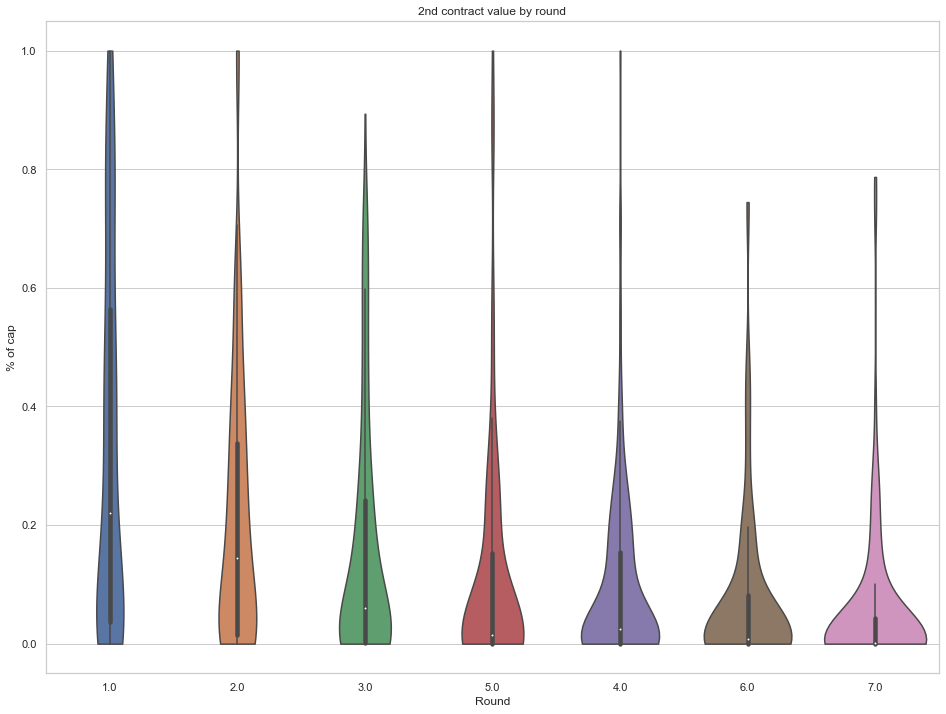

In [280]:
x = 'rnd'
y = 'gtd2_norm_scaled'

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(16,12))

mean_values = df.groupby(x)[y].mean()
sorted_x_categories = mean_values.sort_values(ascending=False).index

# Create the violin plot
sns.violinplot(x=x, y=y, data=df, cut=0, order=sorted_x_categories)

plt.xlabel('Round')
plt.ylabel('% of cap')
plt.title('2nd contract value by round')

plt.show()

In [ ]:
df['gtds_delta'] = df['gtd2_norm_scaled'] - df['gtd1_norm_scaled']

,draft_year,rnd,pick,tm,player,pos,g,matching_name,gtd1_norm,gtd2_norm,year_1,year_2
0,2005,1.0,1.0,SFO,Alex Smith,QB,174.0,Alex Smith,0.467251,0.032520,2005.0,2009.0
5,2005,1.0,6.0,TEN,Adam Jones,DB,146.0,Adam Jones,0.159415,0.000000,2005.0,2008.0
7,2005,1.0,8.0,ARI,Antrel Rolle,DB,155.0,Antrel Rolle,0.152398,0.123267,2005.0,2010.0
8,2005,1.0,9.0,WAS,Carlos Rogers,DB,133.0,Carlos Rogers,0.118789,0.000000,2005.0,2010.0
15,2005,1.0,14.0,CAR,Thomas Davis,LB,199.0,Thomas Davis,0.095906,0.000000,2005.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3122,2017,7.0,234.0,LAR,Ejuan Price,DE,1.0,Ejuan Price,0.000496,0.000000,2017.0,2018.0
3125,2017,7.0,238.0,GNB,Devante Mays,RB,8.0,Devante Mays,0.000449,0.000000,2017.0,2018.0
3126,2017,7.0,239.0,DAL,Noah Brown,WR,66.0,Noah Brown,0.000431,0.000753,2017.0,2021.0
3129,2017,7.0,243.0,HOU,Kyle Fuller,C,51.0,Kyle Fuller,0.072835,0.000414,2014.0,2017.0


In [ ]:
x = df['pick']
y = df['gtd1_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of first contract by pick no.')
plt.show()